In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(2017)

from keras.datasets import mnist
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import adam_v2
from keras import initializers
from tqdm import tnrange

In [ ]:
# データ
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)

# 入力の形状を変換
X_train = X_train.reshape(60000, 28*28)
# 入力を(-1, 1)の範囲に正規化
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28)
X_train reshape: (60000, 784)


In [ ]:
# 潜在空間の次元数
latent_dim = 100

# 画像の次元数 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# 生成器のネットワーク
generator = Sequential()

# 入力層と隠れ層1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# 隠れ層 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# 隠れ層 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# 出力層
generator.add(Dense(img_dim, activation='tanh'))

# モデルの要約表現の出力
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [ ]:
# 敵対者ネットワーク
adversarial = Sequential()

# 入力層と隠れ層1
adversarial.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
adversarial.add(LeakyReLU(alpha=0.2))

# 隠れ層 2
adversarial.add(Dense(256))
adversarial.add(LeakyReLU(alpha=0.2))

# 隠れ層 3
adversarial.add(Dense(512))
adversarial.add(LeakyReLU(alpha=0.2))

# 出力層
adversarial.add(Dense(1, activation='sigmoid'))

# 最適化器
optimizer = adam_v2.Adam(lr=0.0004, beta_1=0.5)

adversarial.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# モデルの要約表現の出力
adversarial.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
adversarial.trainable = False

gan_model = Sequential()
gan_model.add(generator)
gan_model.add(adversarial)
gan_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# モデルの要約表現の出力
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 784)               583312    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 265601    
                                                                 
Total params: 848,913
Trainable params: 581,520
Non-trainable params: 267,393
_________________________________________________________________


In [ ]:
def train(batch_size=256, train_steps=2000):
    adversarial_losses = []
    gan_losses = []
    sample_images = []
    
    for i in tnrange(train_steps):
              
        # 訓練データからランダムにサンプルを選択
        images_train = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        
        # 生成器が偽物の画像を生成するための入力となるノイズを生成
        noise = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
        images_fake = generator.predict(noise)
        
        # 本物/偽物の画像を結合し，適切なラベルを付与して入力を作成
        input_data = np.concatenate((images_train, images_fake))
        input_labels = np.ones([2*batch_size, 1])
        input_labels[batch_size:, :] = 0
        adversarial_loss = adversarial.train_on_batch(input_data, input_labels)
           
        # より本物に近い画像を生成するよう敵対者モデルを訓練
        input_labels = np.ones([batch_size, 1])
        noise = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
        gan_loss = gan_model.train_on_batch(noise, input_labels)
        
        adversarial_losses.append(adversarial_loss)
        gan_losses.append(gan_loss)

        if i % 100 == 0:
            noise = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
            fake_images = generator.predict(noise)
            sample_images.append(fake_images[0])
    
    return adversarial_losses, gan_losses, sample_images

In [ ]:
adversarial_losses, gan_losses, sample_images = train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/2000 [00:00<?, ?it/s]

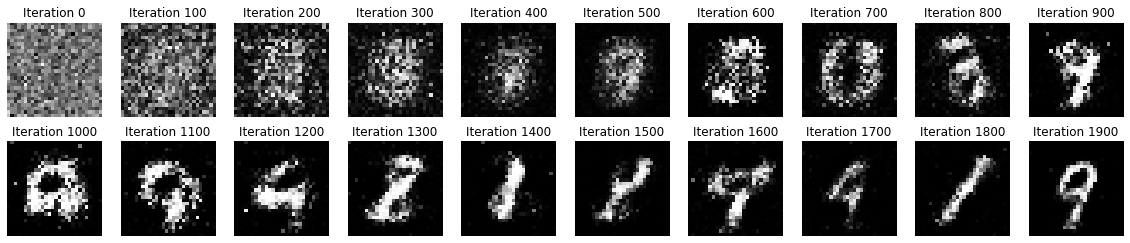

In [ ]:
plt.figure(figsize=(20,4))

for i, fake_image in enumerate(sample_images, 0):
    plt.subplot(2, 10, i+1)
    plt.imshow(np.reshape(fake_image, (28, 28)), cmap='gray')
    plt.title("Iteration %d" % (i * 100))
    plt.axis('off')

Text(0.5, 1.0, 'GAN Accuracy')

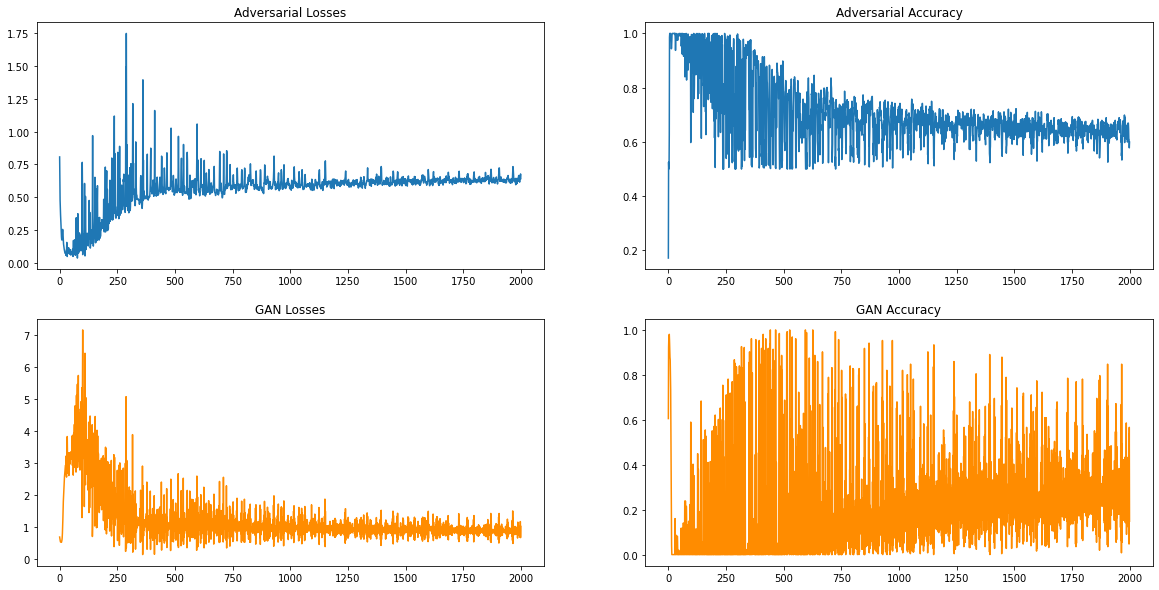

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(np.array(adversarial_losses)[:, 0])
plt.title("Adversarial Losses")

plt.subplot(2,2,2)
plt.plot(np.array(adversarial_losses)[:, 1])
plt.title("Adversarial Accuracy")

plt.subplot(2,2,3)
plt.plot(np.array(gan_losses)[:, 0], color='darkorange')
plt.title("GAN Losses")

plt.subplot(2,2,4)
plt.plot(np.array(gan_losses)[:, 1], color='darkorange')
plt.title("GAN Accuracy")